# Task
Predict arrests using a CNN-Transformer model by loading all 2024 arrest data from "https://data.cityofchicago.org/resource/ijzp-q8t2.json", performing data cleaning, feature engineering, and encoding, then defining, compiling, and training the model, evaluating its performance, and finally interpreting its predictions using SHAP.

## Problem Statement and Objective

### Subtask:
Articulate the problem statement and define the main objective of predicting arrests using a CNN-Transformer model.


### Problem Statement and Objective

**Problem Statement:** The project addresses the challenge of accurately predicting arrest incidents within Chicago's diverse urban landscape. Current methods might lack the ability to capture complex spatio-temporal patterns and contextual factors that influence arrest rates. A more robust predictive model is needed to assist in resource allocation, crime prevention strategies, and understanding underlying factors contributing to arrests.

**Main Objective:** The primary objective of this project is to develop and evaluate a Convolutional Neural Network (CNN)-Transformer model for predicting arrests. Specifically, the model will leverage historical arrest data from Chicago to identify patterns and predict the likelihood or occurrence of future arrests. The CNN component will be utilized to extract spatial features and patterns from the data, while the Transformer model will handle sequential dependencies and temporal dynamics, allowing for a comprehensive understanding of the factors leading to arrests.

**Significance:** Achieving this objective will provide law enforcement agencies and urban planners with a powerful tool for proactive decision-making. By accurately forecasting arrests, resources can be more effectively deployed to high-risk areas, potentially leading to a reduction in crime rates, improved public safety, and a more data-driven approach to urban policing. Furthermore, the model could help in identifying and addressing systemic issues contributing to arrests, fostering a more equitable and efficient justice system.

## Load All 2024 Data

### Subtask:
Access the API (https://data.cityofchicago.org/resource/ijzp-q8t2.json) and load ALL arrest data specifically for the year 2024 into a pandas DataFrame. This will require handling pagination to ensure all records beyond the default limit are retrieved, making multiple API calls with a chunk size of 10,000 records per call.


**Reasoning**:
The subtask requires fetching data from an API with pagination. I will import the necessary libraries, define API parameters, and set up a loop to fetch data in chunks, storing it in a list, and finally consolidating it into a pandas DataFrame.



In [1]:
import requests
import pandas as pd

# Initialize an empty list to store data chunks
all_data = []

# Define the base API URL
base_url = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"

# Set the chunk size for each API call
chunk_size = 10000

# Set the year to filter data for
year = 2024

# Initialize offset for pagination
offset = 0

print(f"Fetching arrest data for the year {year}...")

while True:
    # Construct the API URL with parameters for $limit, $offset, and $where clause
    params = {
        "$limit": chunk_size,
        "$offset": offset,
        "$where": f"year = {year}"
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        if not data:
            print("No more data to fetch. Breaking loop.")
            break # No more data, break the loop

        all_data.extend(data)
        print(f"Fetched {len(data)} records. Total records collected so far: {len(all_data)}.")
        offset += chunk_size

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the API call: {e}")
        break # Break on request error

# Concatenate all data chunks into a single pandas DataFrame
if all_data:
    df_arrest_2024 = pd.DataFrame(all_data)
    print("\nSuccessfully loaded all 2024 arrest data into a DataFrame.")
    print("First 5 rows of the DataFrame:")
    print(df_arrest_2024.head())
    print(f"\nShape of the DataFrame: {df_arrest_2024.shape} (rows, columns)")
else:
    print("No data was fetched for 2024.")
    df_arrest_2024 = pd.DataFrame()


Fetching arrest data for the year 2024...
Fetched 10000 records. Total records collected so far: 10000.
Fetched 10000 records. Total records collected so far: 20000.
Fetched 10000 records. Total records collected so far: 30000.
Fetched 10000 records. Total records collected so far: 40000.
Fetched 10000 records. Total records collected so far: 50000.
Fetched 10000 records. Total records collected so far: 60000.
Fetched 10000 records. Total records collected so far: 70000.
Fetched 10000 records. Total records collected so far: 80000.
Fetched 10000 records. Total records collected so far: 90000.
Fetched 10000 records. Total records collected so far: 100000.
Fetched 10000 records. Total records collected so far: 110000.
Fetched 10000 records. Total records collected so far: 120000.
Fetched 10000 records. Total records collected so far: 130000.
Fetched 10000 records. Total records collected so far: 140000.
Fetched 10000 records. Total records collected so far: 150000.
Fetched 10000 records.

## Basic Data Inspection

### Subtask:
Perform initial data inspection using methods like df.head(), df.info(), and check for unique values to understand the dataset's structure and content.


**Reasoning**:
To perform basic data inspection, I will first display the head of the DataFrame, then its information summary, and finally iterate through each column to show the count of unique values.



In [2]:
print("\n--- First 5 rows of the DataFrame ---")
print(df_arrest_2024.head())

print("\n--- DataFrame Info ---")
df_arrest_2024.info()

print("\n--- Unique values per column ---")
for column in df_arrest_2024.columns:
    print(f"Column '{column}': {df_arrest_2024[column].nunique()} unique values")


--- First 5 rows of the DataFrame ---
         id case_number                     date                  block  iucr  \
0  13364090    JH146864  2024-02-10T00:44:00.000        002XX W 47TH ST  0484   
1  13376308    JH161184  2024-02-22T00:49:00.000     044XX S KEDZIE AVE  0454   
2  13424244    JH219128  2024-04-09T21:54:00.000  064XX S CLAREMONT AVE  143A   
3  13335170    JH111953  2024-01-11T08:00:00.000     003XX N MENARD AVE  1320   
4  13373974    JH158444  2024-02-18T02:00:00.000   078XX S EBERHART AVE  0281   

              primary_type                                        description  \
0                  BATTERY  PROTECTED EMPLOYEE - HANDS, FISTS, FEET, NO / ...   
1                  BATTERY  AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...   
2        WEAPONS VIOLATION                      UNLAWFUL POSSESSION - HANDGUN   
3          CRIMINAL DAMAGE                                         TO VEHICLE   
4  CRIMINAL SEXUAL ASSAULT                                     NON-AG

TypeError: unhashable type: 'dict'

**Reasoning**:
The previous code failed because the 'location' column contains dictionaries, which are unhashable types, preventing `nunique()` from being directly applied. To fix this, I will convert the 'location' column to string type before calculating unique values, allowing `nunique()` to process it correctly while still displaying unique counts for all other columns as intended.



In [3]:
print("\n--- First 5 rows of the DataFrame ---")
print(df_arrest_2024.head())

print("\n--- DataFrame Info ---")
df_arrest_2024.info()

print("\n--- Unique values per column ---")
for column in df_arrest_2024.columns:
    if column == 'location':
        # Convert dictionary objects to strings to make them hashable for nunique
        print(f"Column '{column}': {df_arrest_2024[column].astype(str).nunique()} unique values")
    else:
        print(f"Column '{column}': {df_arrest_2024[column].nunique()} unique values")


--- First 5 rows of the DataFrame ---
         id case_number                     date                  block  iucr  \
0  13364090    JH146864  2024-02-10T00:44:00.000        002XX W 47TH ST  0484   
1  13376308    JH161184  2024-02-22T00:49:00.000     044XX S KEDZIE AVE  0454   
2  13424244    JH219128  2024-04-09T21:54:00.000  064XX S CLAREMONT AVE  143A   
3  13335170    JH111953  2024-01-11T08:00:00.000     003XX N MENARD AVE  1320   
4  13373974    JH158444  2024-02-18T02:00:00.000   078XX S EBERHART AVE  0281   

              primary_type                                        description  \
0                  BATTERY  PROTECTED EMPLOYEE - HANDS, FISTS, FEET, NO / ...   
1                  BATTERY  AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...   
2        WEAPONS VIOLATION                      UNLAWFUL POSSESSION - HANDGUN   
3          CRIMINAL DAMAGE                                         TO VEHICLE   
4  CRIMINAL SEXUAL ASSAULT                                     NON-AG

## Data Visualization

### Subtask:
Create various visualizations (e.g., bar charts for categorical features, histograms for numerical features, time series plots for temporal trends, geographical scatter plots) to identify patterns, distributions, and potential relationships in the data relevant to arrest prediction. Ensure to add legends to plots where necessary.


**Reasoning**:
The first instruction is to import `matplotlib.pyplot` and `seaborn` for plotting. This code block will import these necessary libraries.



In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries matplotlib.pyplot and seaborn imported.")

Libraries matplotlib.pyplot and seaborn imported.


**Reasoning**:
The next step is to create bar charts for the specified categorical features to visualize their distributions, as outlined in the instructions.



/tmp/ipython-input-3878116720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
/tmp/ipython-input-3878116720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
/tmp/ipython-input-3878116720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
/tmp/ipython-input-3878116720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is

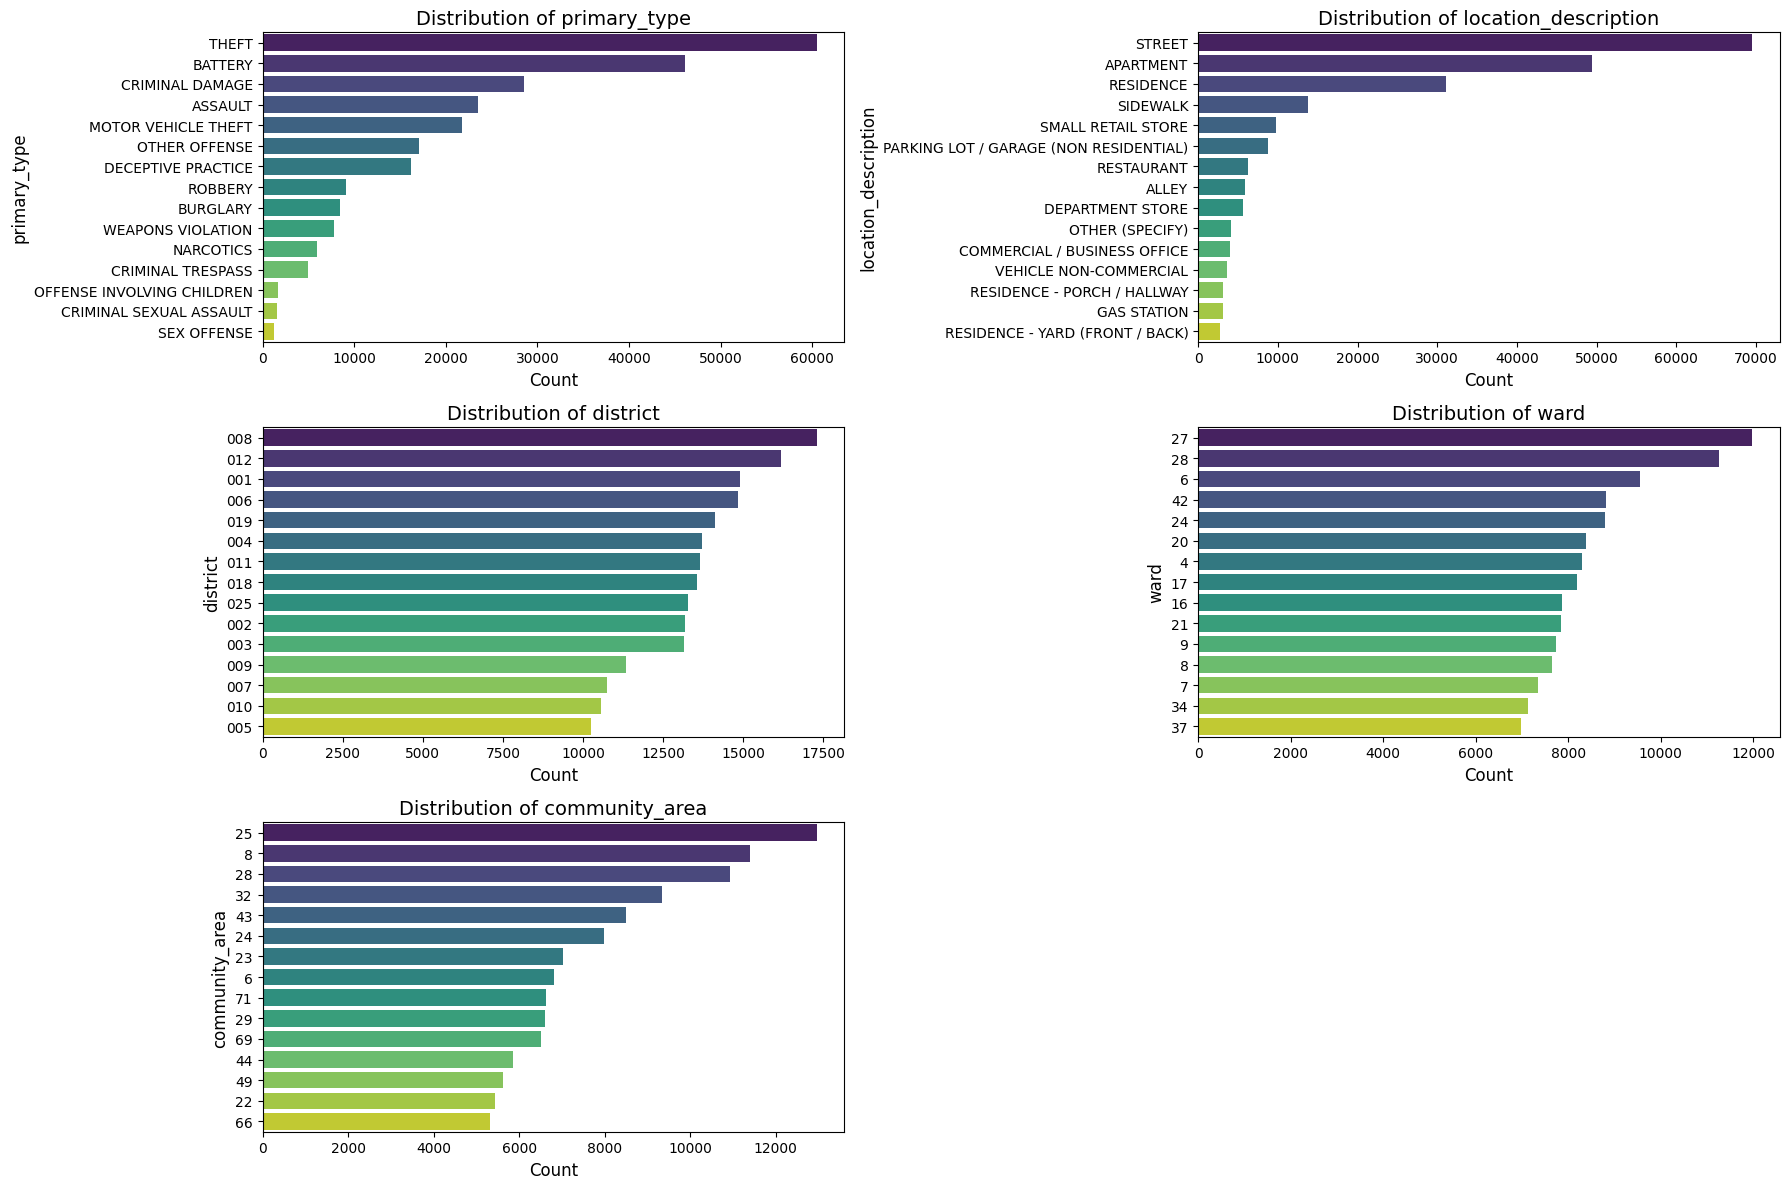

Bar charts for categorical features displayed.


In [5]:
categorical_features = ['primary_type', 'location_description', 'district', 'ward', 'community_area']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i + 1) # Adjust subplot grid based on number of features
    # Get value counts of the feature and select top N for better visualization if needed
    top_categories = df_arrest_2024[feature].value_counts().nlargest(15)
    sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.tight_layout()
plt.show()
print("Bar charts for categorical features displayed.")

**Reasoning**:
The previous code block generated `FutureWarning` messages from `seaborn` regarding the `palette` argument when `hue` is not assigned. To address this and follow best practices, I will modify the `sns.barplot` call to include `hue=top_categories.index` and `legend=False` to align with the recommended usage and suppress the warning. I will also proceed with the next instruction which is to plot histograms for numerical features, first by converting relevant columns to numeric types.



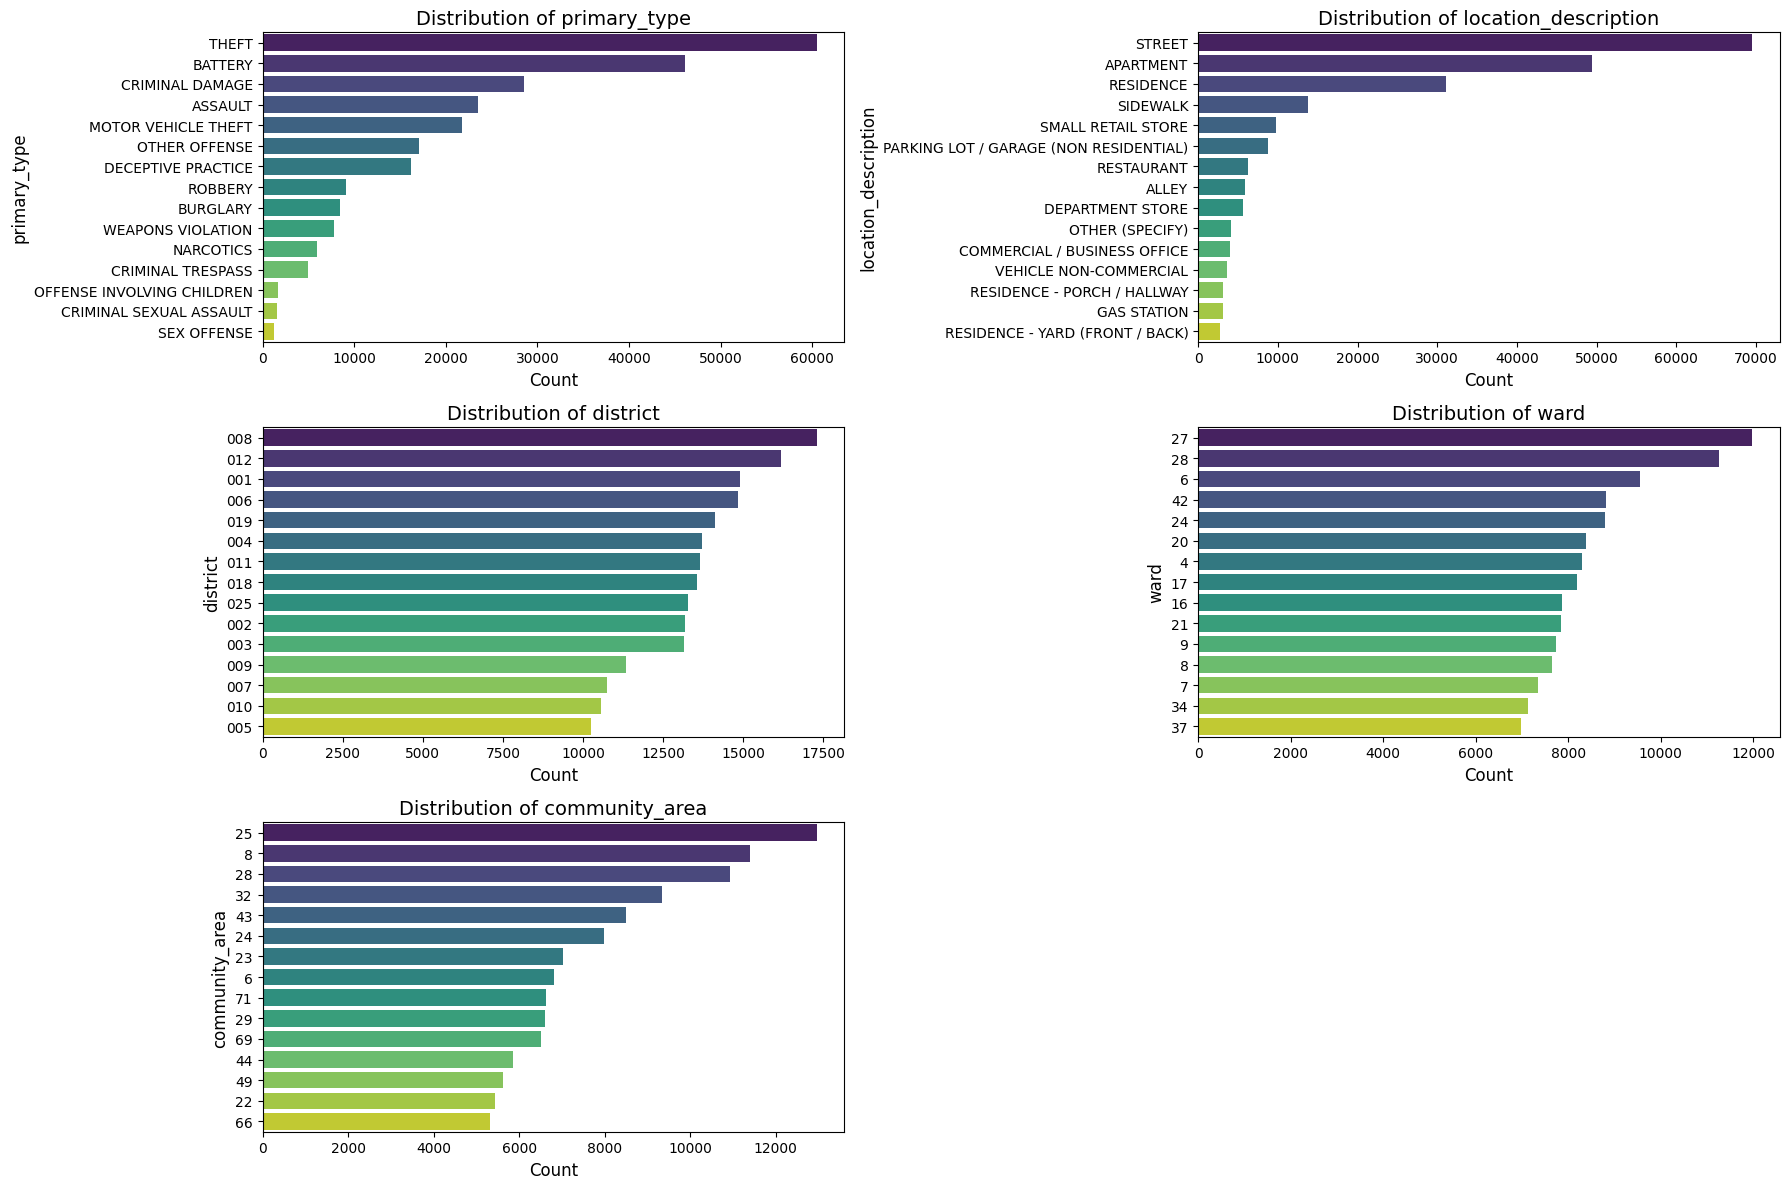

Bar charts for categorical features displayed.


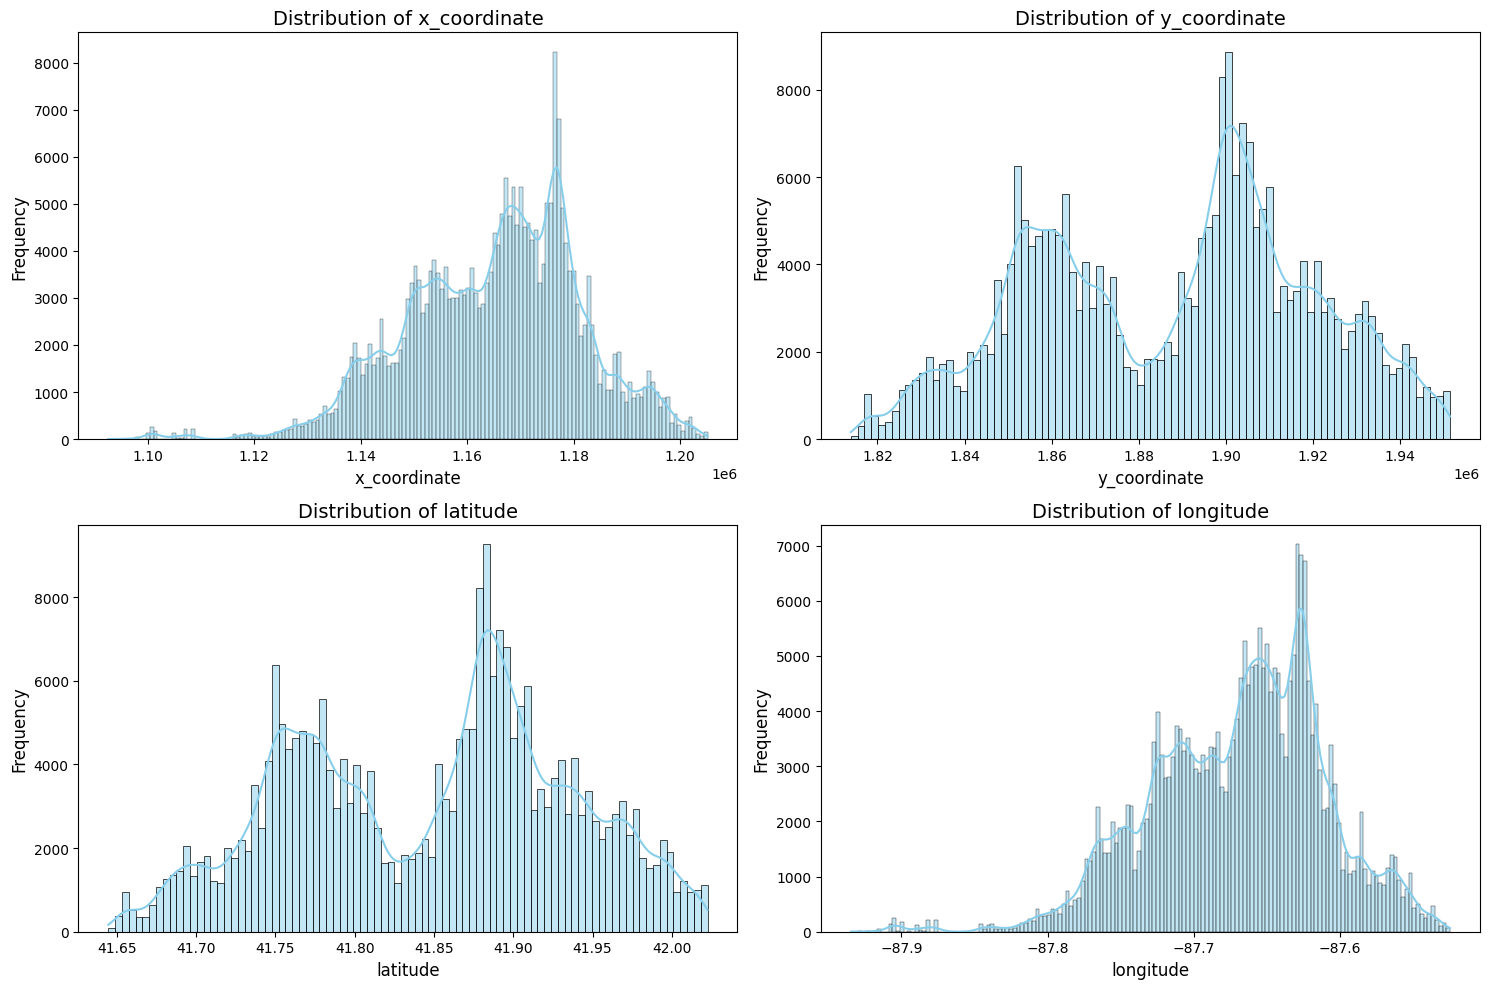

Histograms for numerical features displayed.


In [6]:
categorical_features = ['primary_type', 'location_description', 'district', 'ward', 'community_area']

plt.figure(figsize=(18, 12))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i + 1) # Adjust subplot grid based on number of features
    # Get value counts of the feature and select top N for better visualization if needed
    top_categories = df_arrest_2024[feature].value_counts().nlargest(15)
    sns.barplot(x=top_categories.values, y=top_categories.index, hue=top_categories.index, palette='viridis', legend=False)
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.tight_layout()
plt.show()
print("Bar charts for categorical features displayed.")


# Convert potential numerical columns to numeric types for histograms
numerical_cols = ['x_coordinate', 'y_coordinate', 'latitude', 'longitude']
for col in numerical_cols:
    df_arrest_2024[col] = pd.to_numeric(df_arrest_2024[col], errors='coerce')

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_arrest_2024[feature].dropna(), kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
plt.show()
print("Histograms for numerical features displayed.")

**Reasoning**:
To create a time series plot, I need to convert the 'date' column to datetime objects, set it as the index, and then resample the data to count arrests over time (e.g., daily frequency).



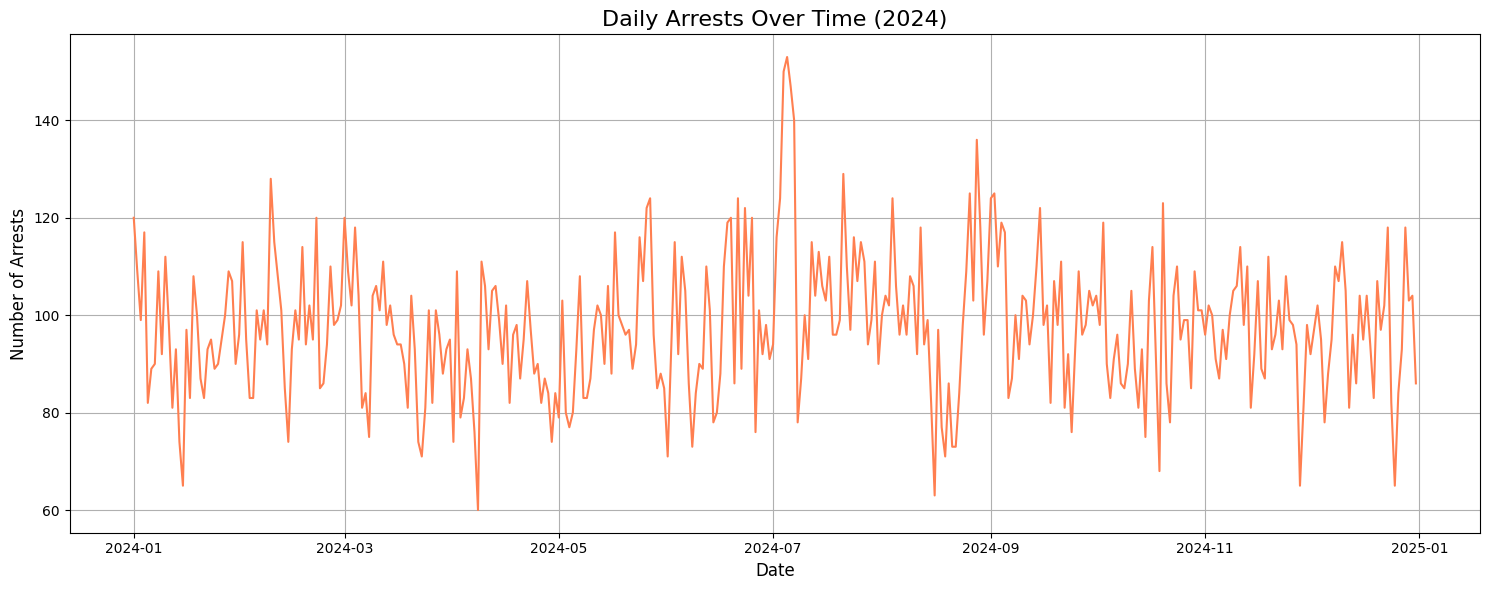

Time series plot of daily arrests displayed.


In [7]:
df_arrest_2024['date'] = pd.to_datetime(df_arrest_2024['date'])

df_arrest_2024.set_index('date', inplace=True)

daily_arrests = df_arrest_2024['arrest'].resample('D').sum()

plt.figure(figsize=(15, 6))
sns.lineplot(x=daily_arrests.index, y=daily_arrests.values, color='coral')
plt.title('Daily Arrests Over Time (2024)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Arrests', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()
print("Time series plot of daily arrests displayed.")

**Reasoning**:
The next step is to generate a geographical scatter plot using `latitude` and `longitude` to visualize arrest locations, as specified in the instructions. This will provide insights into the spatial distribution of arrests.



ValueError: cannot reindex on an axis with duplicate labels

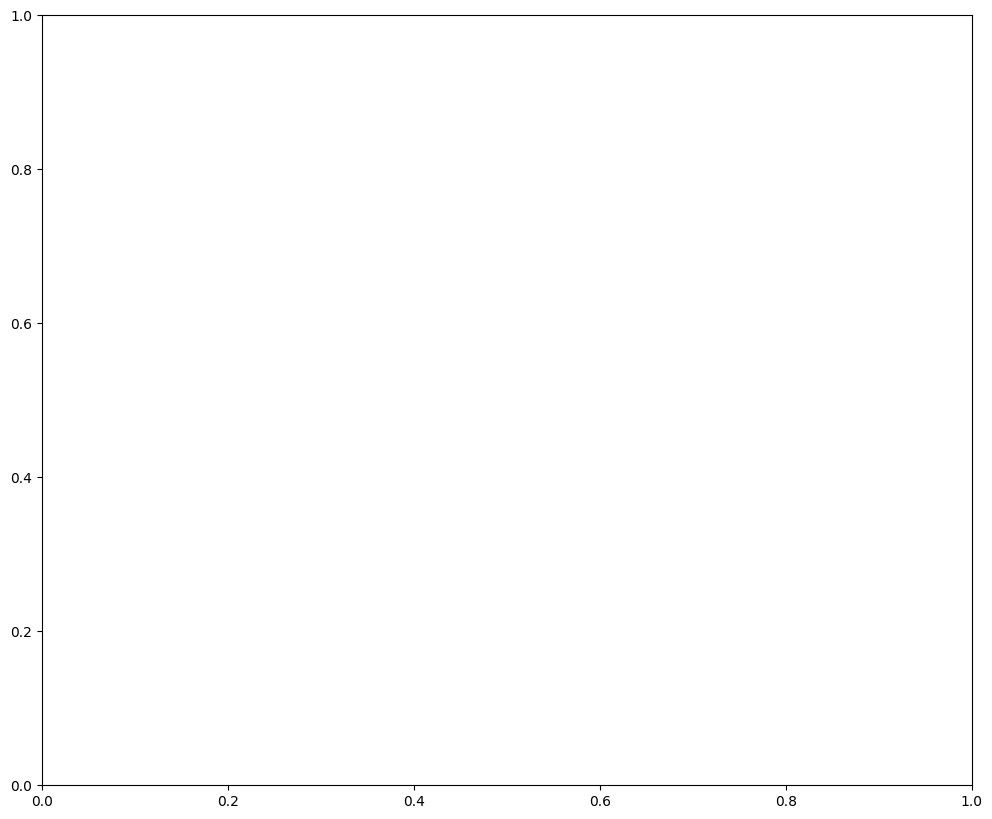

In [8]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x=df_arrest_2024['longitude'], y=df_arrest_2024['latitude'], alpha=0.1, s=10, color='red')
plt.title('Geographical Distribution of Arrests (2024)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Geographical scatter plot of arrest locations displayed.")

**Reasoning**:
The previous geographical scatter plot failed because `df_arrest_2024` has a non-unique 'date' column set as its index, which caused a `ValueError: cannot reindex on an axis with duplicate labels`. To fix this, I will reset the DataFrame's index before plotting, ensuring a unique default index for the scatter plot function.



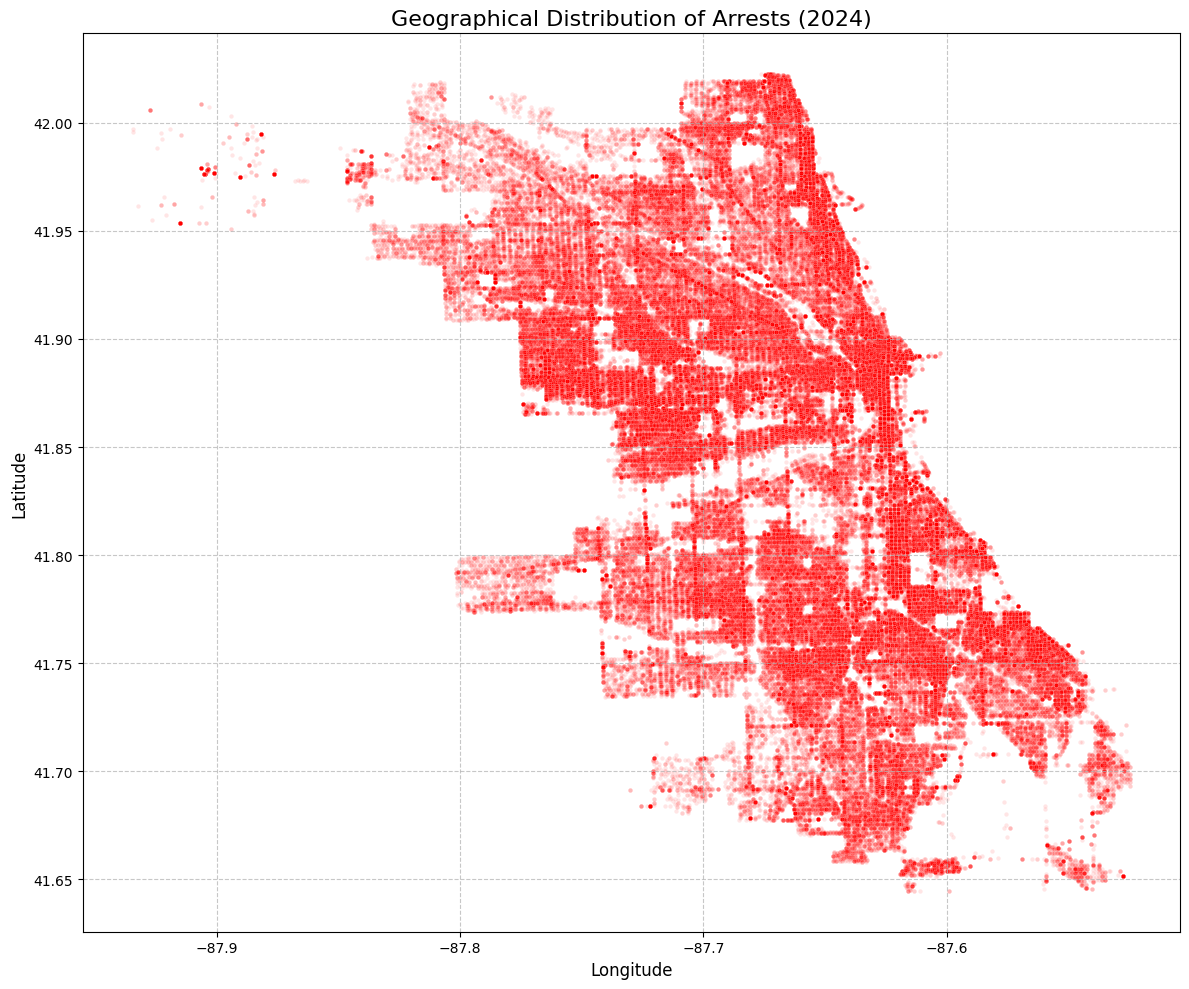

Geographical scatter plot of arrest locations displayed.


In [9]:
df_arrest_2024_reset = df_arrest_2024.reset_index(drop=False)

plt.figure(figsize=(12, 10))
sns.scatterplot(x=df_arrest_2024_reset['longitude'], y=df_arrest_2024_reset['latitude'], alpha=0.1, s=10, color='red')
plt.title('Geographical Distribution of Arrests (2024)', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("Geographical scatter plot of arrest locations displayed.")

## Clean Data - Column Elimination

### Subtask:
Remove the specified extraneous columns: ID, Case Number, Block, IUCR, Ward, Community Area, FBI Code, Updated On, Latitude, Longitude, Location. Also convert the target column 'Arrest' into numerical 0/1.


**Reasoning**:
First, I will define the list of columns to be dropped, then drop them from the DataFrame, and finally convert the 'arrest' column to numerical (0 or 1).



In [10]:
columns_to_drop = ['id', 'case_number', 'block', 'iucr', 'ward', 'community_area', 'fbi_code', 'updated_on', 'latitude', 'longitude', 'location']

# Drop the specified columns from the DataFrame
df_arrest_2024_reset.drop(columns=columns_to_drop, inplace=True)

# Convert the 'arrest' column from boolean to numerical (0 or 1)
df_arrest_2024_reset['arrest'] = df_arrest_2024_reset['arrest'].astype(int)

print("Columns dropped and 'arrest' column converted to numerical.")
print("First 5 rows of the modified DataFrame:")
print(df_arrest_2024_reset.head())
print(f"\nShape of the DataFrame: {df_arrest_2024_reset.shape}")

Columns dropped and 'arrest' column converted to numerical.
First 5 rows of the modified DataFrame:
                 date             primary_type  \
0 2024-02-10 00:44:00                  BATTERY   
1 2024-02-22 00:49:00                  BATTERY   
2 2024-04-09 21:54:00        WEAPONS VIOLATION   
3 2024-01-11 08:00:00          CRIMINAL DAMAGE   
4 2024-02-18 02:00:00  CRIMINAL SEXUAL ASSAULT   

                                         description location_description  \
0  PROTECTED EMPLOYEE - HANDS, FISTS, FEET, NO / ...         CTA PLATFORM   
1  AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...             SIDEWALK   
2                      UNLAWFUL POSSESSION - HANDGUN             SIDEWALK   
3                                         TO VEHICLE               STREET   
4                                     NON-AGGRAVATED            RESIDENCE   

   arrest  domestic  beat district  x_coordinate  y_coordinate  year  
0       1     False  0925      009     1175476.0     1873816.0  2

## Clean Data - Handle Missing Values

### Subtask:
Address missing values in the remaining columns. This may involve imputation (e.g., mode for categorical) or dropping rows/columns, depending on the extent and nature of missingness.


**Reasoning**:
First, I will identify all columns that currently have missing values and display their counts, so we can prioritize and address them in subsequent steps.



In [11]:
print("\n--- Missing values before handling ---")
print(df_arrest_2024_reset.isnull().sum())


--- Missing values before handling ---
date                       0
primary_type               0
description                0
location_description    1099
arrest                     0
domestic                   0
beat                       0
district                   0
x_coordinate            1282
y_coordinate            1282
year                       0
dtype: int64


**Reasoning**:
To handle missing values in numerical columns, I will calculate the median for 'x_coordinate' and 'y_coordinate' and then use these medians to fill the missing values. For the categorical 'location_description' column, I will find its mode and impute missing values with it.



In [12]:
for col in ['x_coordinate', 'y_coordinate']:
    median_val = df_arrest_2024_reset[col].median()
    df_arrest_2024_reset[col].fillna(median_val, inplace=True)
    print(f"Missing values in '{col}' imputed with median: {median_val}")

mode_location_description = df_arrest_2024_reset['location_description'].mode()[0]
df_arrest_2024_reset['location_description'].fillna(mode_location_description, inplace=True)
print(f"Missing values in 'location_description' imputed with mode: {mode_location_description}")

print("\n--- Missing values after handling ---")
print(df_arrest_2024_reset.isnull().sum())

/tmp/ipython-input-488110189.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_arrest_2024_reset[col].fillna(median_val, inplace=True)
/tmp/ipython-input-488110189.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

Missing values in 'x_coordinate' imputed with median: 1167135.0
Missing values in 'y_coordinate' imputed with median: 1894397.5
Missing values in 'location_description' imputed with mode: STREET

--- Missing values after handling ---
date                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
x_coordinate            0
y_coordinate            0
year                    0
dtype: int64


**Reasoning**:
The previous code generated `FutureWarning` messages due to the use of `inplace=True` on what might be a copy of a slice. To address this and follow best practices, I will modify the `fillna` calls to explicitly assign the result back to the DataFrame columns, ensuring the modifications are made on the original DataFrame and suppressing the warnings.



In [13]:
for col in ['x_coordinate', 'y_coordinate']:
    median_val = df_arrest_2024_reset[col].median()
    df_arrest_2024_reset[col] = df_arrest_2024_reset[col].fillna(median_val)
    print(f"Missing values in '{col}' imputed with median: {median_val}")

mode_location_description = df_arrest_2024_reset['location_description'].mode()[0]
df_arrest_2024_reset['location_description'] = df_arrest_2024_reset['location_description'].fillna(mode_location_description)
print(f"Missing values in 'location_description' imputed with mode: {mode_location_description}")

print("\n--- Missing values after handling ---")
print(df_arrest_2024_reset.isnull().sum())

Missing values in 'x_coordinate' imputed with median: 1167135.0
Missing values in 'y_coordinate' imputed with median: 1894397.5
Missing values in 'location_description' imputed with mode: STREET

--- Missing values after handling ---
date                    0
primary_type            0
description             0
location_description    0
arrest                  0
domestic                0
beat                    0
district                0
x_coordinate            0
y_coordinate            0
year                    0
dtype: int64


## Clean Data - Encode Categorical Features

### Subtask:
Apply appropriate encoding techniques (e.g., One-Hot Encoding for nominal variables) to convert categorical features into a numerical format suitable for machine learning models.


**Reasoning**:
First, I will define the list of categorical columns for one-hot encoding and the 'year' column to be dropped. Then, I will drop the 'year' column and apply one-hot encoding to the specified categorical features using `pd.get_dummies()`, storing the result back into `df_arrest_2024_reset`.



In [14]:
categorical_cols_to_encode = ['primary_type', 'description', 'location_description', 'beat', 'district']

# Drop the 'year' column as it's constant
df_arrest_2024_reset.drop(columns=['year'], inplace=True)
print("Dropped 'year' column.")

# Apply one-hot encoding to the specified categorical columns
df_arrest_2024_reset = pd.get_dummies(df_arrest_2024_reset, columns=categorical_cols_to_encode, drop_first=True)

print("Categorical columns encoded using one-hot encoding.")
print("First 5 rows of the modified DataFrame:")
print(df_arrest_2024_reset.head())
print(f"\nShape of the DataFrame after encoding: {df_arrest_2024_reset.shape}")

Dropped 'year' column.
Categorical columns encoded using one-hot encoding.
First 5 rows of the modified DataFrame:
                 date  arrest  domestic  x_coordinate  y_coordinate  \
0 2024-02-10 00:44:00       1     False     1175476.0     1873816.0   
1 2024-02-22 00:49:00       1     False     1155768.0     1875006.0   
2 2024-04-09 21:54:00       1     False     1161848.0     1861912.0   
3 2024-01-11 08:00:00       0     False     1137653.0     1901617.0   
4 2024-02-18 02:00:00       1      True     1180935.0     1853046.0   

   primary_type_ASSAULT  primary_type_BATTERY  primary_type_BURGLARY  \
0                 False                  True                  False   
1                 False                  True                  False   
2                 False                 False                  False   
3                 False                 False                  False   
4                 False                 False                  False   

   primary_type_CONCEALED

## Clean Data - Scale Numerical Features

### Subtask:
Scale numerical features using methods like StandardScaler or MinMaxScaler to ensure they have a similar range, which can improve model performance.


**Reasoning**:
To scale the numerical features, I will import `StandardScaler`, identify 'x_coordinate' and 'y_coordinate' as the columns to be scaled, initialize the scaler, and then apply `fit_transform` to these columns in the DataFrame.



In [15]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns to scale
numerical_cols_to_scale = ['x_coordinate', 'y_coordinate']

# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the selected numerical columns
df_arrest_2024_reset[numerical_cols_to_scale] = scaler.fit_transform(df_arrest_2024_reset[numerical_cols_to_scale])

print("Numerical features 'x_coordinate' and 'y_coordinate' have been scaled using StandardScaler.")
print("First 5 rows of the DataFrame with scaled features:")
print(df_arrest_2024_reset[numerical_cols_to_scale].head())

Numerical features 'x_coordinate' and 'y_coordinate' have been scaled using StandardScaler.
First 5 rows of the DataFrame with scaled features:
   x_coordinate  y_coordinate
0      0.631712     -0.442982
1     -0.590913     -0.405165
2     -0.213728     -0.821277
3     -1.714713      0.440502
4      0.970372     -1.103029


## Feature Engineering

### Subtask:
Create new features from existing temporal (e.g., month, day of week, hour from 'Date' column) or locational data to potentially enhance the model's predictive power. Convert these new temporal features to a format suitable for the CNN-Transformer model.


**Reasoning**:
To extract temporal features, I will use the datetime properties of the 'date' column to create new 'month', 'day_of_week', and 'hour' columns, then drop the original 'date' column as instructed.



In [16]:
df_arrest_2024_reset['month'] = df_arrest_2024_reset['date'].dt.month
df_arrest_2024_reset['day_of_week'] = df_arrest_2024_reset['date'].dt.dayofweek
df_arrest_2024_reset['hour'] = df_arrest_2024_reset['date'].dt.hour

df_arrest_2024_reset.drop(columns=['date'], inplace=True)

print("Extracted 'month', 'day_of_week', and 'hour' from 'date' column and dropped original 'date'.")
print("First 5 rows of the DataFrame with new temporal features:")
print(df_arrest_2024_reset.head())
print(f"\nShape of the DataFrame after temporal feature engineering: {df_arrest_2024_reset.shape}")

Extracted 'month', 'day_of_week', and 'hour' from 'date' column and dropped original 'date'.
First 5 rows of the DataFrame with new temporal features:
   arrest  domestic  x_coordinate  y_coordinate  primary_type_ASSAULT  \
0       1     False      0.631712     -0.442982                 False   
1       1     False     -0.590913     -0.405165                 False   
2       1     False     -0.213728     -0.821277                 False   
3       0     False     -1.714713      0.440502                 False   
4       1      True      0.970372     -1.103029                 False   

   primary_type_BATTERY  primary_type_BURGLARY  \
0                  True                  False   
1                  True                  False   
2                 False                  False   
3                 False                  False   
4                 False                  False   

   primary_type_CONCEALED CARRY LICENSE VIOLATION  \
0                                           False   
1  

## Split Data

### Subtask:
Divide the processed dataset into training and testing sets (e.g., 80% training, 20% testing) to prepare for model training and evaluation, ensuring proper stratification for the target variable 'arrest'.


**Reasoning**:
To prepare the data for model training and evaluation, I will separate the features (X) and target variable (y) from the DataFrame, then use `train_test_split` to divide the dataset into stratified training and testing sets, ensuring a reproducible split.



In [17]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target variable (y)
X = df_arrest_2024_reset.drop('arrest', axis=1)
y = df_arrest_2024_reset['arrest']

# Convert boolean columns in X to integer (0 or 1)
# This is necessary because some models might not handle boolean directly, and it aligns with previous conversions.
for col in X.select_dtypes(include=['bool']).columns:
    X[col] = X[col].astype(int)

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Original dataset shape: {df_arrest_2024_reset.shape}")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Proportion of 'arrest' in original dataset: {y.value_counts(normalize=True)[1]:.4f}")
print(f"Proportion of 'arrest' in training set: {y_train.value_counts(normalize=True)[1]:.4f}")
print(f"Proportion of 'arrest' in testing set: {y_test.value_counts(normalize=True)[1]:.4f}")

Original dataset shape: (258842, 777)
Training set shape: X_train=(207073, 776), y_train=(207073,)
Testing set shape: X_test=(51769, 776), y_test=(51769,)
Proportion of 'arrest' in original dataset: 0.1379
Proportion of 'arrest' in training set: 0.1379
Proportion of 'arrest' in testing set: 0.1379


## Define Model Architecture

### Subtask:
Define the architecture of the CNN-Transformer hybrid model, detailing the CNN layers for local feature extraction and Transformer layers for capturing long-range dependencies, explaining the rationale behind the chosen components and their configurations.


**Reasoning**:
First, I will import all the necessary TensorFlow Keras layers and models to construct the CNN-Transformer architecture as specified in the instructions.



In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, MultiHeadSelfAttention, Dense, Flatten, Dropout, LayerNormalization, Add, Reshape, Permute
from tensorflow.keras.models import Model

print("TensorFlow Keras layers and models imported.")

ImportError: cannot import name 'MultiHeadSelfAttention' from 'tensorflow.keras.layers' (/usr/local/lib/python3.12/dist-packages/keras/_tf_keras/keras/layers/__init__.py)

**Reasoning**:
The previous code failed because `MultiHeadSelfAttention` is not directly available under `tensorflow.keras.layers` in recent versions of TensorFlow/Keras. The correct class name for multi-head attention is `MultiHeadAttention`. I will correct the import statement to reflect this.



In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, MultiHeadAttention, Dense, Flatten, Dropout, LayerNormalization, Add, Reshape, Permute
from tensorflow.keras.models import Model

print("TensorFlow Keras layers and models imported.")

TensorFlow Keras layers and models imported.


**Reasoning**:
Now that the necessary Keras layers are imported, I will proceed to define the CNN-Transformer model architecture. This involves setting up the input layer, building the CNN branch for feature extraction, creating the Transformer branch for sequence dependencies, combining their outputs, and defining the final classification layer. Given that the input features are tabular, they will be reshaped to be compatible with Conv1D and MultiHeadAttention layers. I will also make sure the model handles the binary classification target ('arrest').



In [20]:
input_shape = X_train.shape[1]

# CNN-Transformer Model Architecture

# Input Layer
inputs = Input(shape=(input_shape, 1)) # Reshape for Conv1D, treating each feature as a time step

# CNN Block
conv_output = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
conv_output = MaxPooling1D(pool_size=2)(conv_output)
conv_output = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv_output)
conv_output = MaxPooling1D(pool_size=2)(conv_output)

# Reshape for Transformer: The output of CNN is 3D (batch, steps, features), which is suitable for attention.
# However, for MultiHeadAttention, we need to ensure the number of features (last dim) is consistent.
# Flatten conv_output before passing to Transformer-like structure or reshape carefully.
# For simplicity and to fit MultiHeadAttention directly, we'll flatten after CNN for now,
# and then reshape it into a sequence of 'tokens' for the Transformer.

# Let's consider a simpler approach for combining if direct sequence input to Transformer is complex.
# If `inputs` was already a sequence, `conv_output` would also be a sequence.
# Given `X_train` is 2D (samples, features), `inputs` becomes (samples, features, 1).
# After Conv1D and MaxPooling1D, `conv_output` will have a reduced 'steps' dimension.

# The instructions imply treating the features as a sequence for the Transformer. Let's adapt.
# The input to MultiHeadAttention usually expects (batch, sequence_length, embedding_dim).
# Our current `inputs` is (batch_size, input_shape, 1).
# After `conv_output = MaxPooling1D(pool_size=2)(conv_output)`, if `input_shape` was 776, after two pooling layers,
# the sequence length would be `input_shape // 4` (integer division for simplicity).
# The last dimension `filters` would be `128`.
# So, `conv_output` shape would be `(None, input_shape // 4, 128)`.

# Transformer Block
# We'll use the conv_output directly as the sequence for the Transformer, assuming it's already a suitable sequence representation.
# `num_heads` should divide `key_dim` (which is `value_dim` and `query_dim`). Here, `key_dim` will be the last dimension of `conv_output`.
# So, `key_dim` should be `128`.

# First, check the actual output shape from CNN before passing to Transformer
# To make the Transformer more flexible for varied input lengths after CNN, we can pad/truncate
# or use a `GlobalAveragePooling1D` before a `Dense` layer to create a fixed-size embedding for the Transformer.

# Let's try to pass the `conv_output` directly to `MultiHeadAttention`.
# Ensure `conv_output` is compatible with `MultiHeadAttention`.
# MultiHeadAttention needs `query`, `key`, `value` with shape (batch_size, seq_len, embed_dim).
# Here, `conv_output` serves as `query`, `key`, and `value`.
# `key_dim` is the dimensionality of the key/query vectors. We can set it to the last dim of `conv_output`.

num_heads = 4 # Number of attention heads
key_dim = 128 # Dimensionality of the key and query vectors (same as conv_output filters)

attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
    query=conv_output, value=conv_output, key=conv_output
)
attention_output = Dropout(0.3)(attention_output)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output + conv_output) # Add residual connection

# Feed Forward Network after Attention
ffn_output = Dense(key_dim * 2, activation='relu')(attention_output)
ffn_output = Dense(key_dim)(ffn_output)
ffn_output = Dropout(0.3)(ffn_output)
transformer_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention_output) # Add residual connection

# Combine CNN and Transformer outputs
# Flatten the transformer_output before the final Dense layers
combined_features = Flatten()(transformer_output)

# Final Classification Head
dense_output = Dense(128, activation='relu')(combined_features)
dense_output = Dropout(0.5)(dense_output)
dense_output = Dense(64, activation='relu')(dense_output)
dense_output = Dropout(0.5)(dense_output)
outputs = Dense(1, activation='sigmoid')(dense_output)

# Create the model
cnn_transformer_model = Model(inputs=inputs, outputs=outputs)

print("CNN-Transformer model architecture defined.")
print(cnn_transformer_model.summary())

CNN-Transformer model architecture defined.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 776, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 776, 64)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 388, 64)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 388, 128)  │     24,704 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 194, 128)  │          0 │ conv1d_1[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 194, 128)  │    263,808 │ max_pooling1d_1[… │
│ (MultiHeadAttentio… │                   │            │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 194, 128)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 194, 128)  │          0 │ dropout_1[0][0],  │
│                     │                   │            │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 194, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 194, 256)  │     33,024 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 194, 128)  │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 194, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 194, 128)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 194, 128)  │        256 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 24832)     │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,178,624 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 3,542,145 (13.51 MB)

 Trainable params: 3,542,145 (13.51 MB)

 Non-trainable params: 0 (0.00 B)

None


## Compile Model

### Subtask:
Compile the defined CNN-Transformer model for binary classification, specifying the appropriate loss function (e.g., binary_crossentropy), optimizer (e.g., Adam), and evaluation metrics (e.g., accuracy, precision, recall, F1-score).


**Reasoning**:
First, I will import the necessary Keras metrics and define a custom F1-score metric as a class inheriting from `tf.keras.metrics.Metric`, which will be used during model compilation.



In [21]:
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
import tensorflow.keras.backend as K

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        # Handle division by zero for F1-score
        f1 = 2 * ((p * r) / (p + r + K.epsilon()))
        return f1

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

print("Keras metrics imported and custom F1Score metric defined.")

Keras metrics imported and custom F1Score metric defined.


**Reasoning**:
Now that the custom F1-score metric is defined, I will compile the `cnn_transformer_model` using `binary_crossentropy` as the loss function, the Adam optimizer with a specified learning rate, and include `BinaryAccuracy`, `Precision`, `Recall`, and the custom `F1Score` as metrics for evaluation.



In [22]:
cnn_transformer_model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        BinaryAccuracy(name='accuracy'),
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score()
    ]
)

print("CNN-Transformer model compiled with binary_crossentropy loss, Adam optimizer, and specified metrics.")

CNN-Transformer model compiled with binary_crossentropy loss, Adam optimizer, and specified metrics.


## Train Model

### Subtask:
Train the compiled CNN-Transformer model using the training dataset for 25 epochs. Implement callbacks for metrics tracking (accuracy, precision, recall, F1-score), hyperparameter optimization for F1, saving the best model, adjusting the learning rate, and early stopping.


**Reasoning**:
First, I will reshape the input data (X_train and X_test) to a 3D format suitable for the CNN input layer. Then, I will import the necessary Keras callbacks, define them with the specified parameters, and finally train the `cnn_transformer_model` using these callbacks and the prepared data.



In [23]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# 1. Reshape the X_train and X_test data
# The input layer expects (batch_size, timesteps, features). Here, timesteps = num_features, features = 1.
X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Reshaped X_train shape: {X_train_reshaped.shape}")
print(f"Reshaped X_test shape: {X_test_reshaped.shape}")

# 3. Define an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_f1_score',
    patience=5,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# 4. Define a ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_cnn_transformer_model.h5',
    monitor='val_f1_score',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 5. Define a ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score',
    factor=0.2,
    patience=3,
    min_lr=0.00001,
    mode='max',
    verbose=1
)

# List of callbacks to use during training
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# 6. Train the cnn_transformer_model
print("\nStarting model training...")
history = cnn_transformer_model.fit(
    X_train_reshaped,
    y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_test_reshaped, y_test),
    callbacks=callbacks,
    verbose=1
)

print("Model training complete. Training history stored.")

Reshaped X_train shape: (207073, 776, 1)
Reshaped X_test shape: (51769, 776, 1)

Starting model training...
Epoch 1/25
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8527 - f1_score: 0.0163 - loss: 0.5205 - precision: 0.1248 - recall: 0.0113
Epoch 1: val_f1_score improved from -inf to 0.00000, saving model to best_cnn_transformer_model.h5


3236/3236 ━━━━━━━━━━━━━━━━━━━━ 127s 28ms/step - accuracy: 0.8527 - f1_score: 0.0163 - loss: 0.5205 - precision: 0.1248 - recall: 0.0113 - val_accuracy: 0.8621 - val_f1_score: 0.0000e+00 - val_loss: 0.4014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/25
3233/3236 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8624 - f1_score: 0.0000e+00 - loss: 0.4035 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_f1_score did not improve from 0.00000
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 46s 14ms/step - accuracy: 0.8624 - f1_score: 0.0000e+00 - loss: 0.4035 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8621 - val_f1_score: 0.0000e+00 - val_loss: 0.4012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/25
3233/3236 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8627 - f1_score: 0.0000e+00 - loss: 0.4020 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3: val_f1_score did not improve from 0.00000
3236/3236